<a href="https://colab.research.google.com/github/jpsantosz/projeto-final-gerenciamento-de-dados-em-larga-escala/blob/main/Trabalho_Final_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from pyspark.sql import SparkSession
from google.colab import drive
from pyspark.sql import functions as F
from pyspark.sql.window import Window

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
spark = SparkSession.builder \
    .appName("SteamReviews") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

path = "/content/drive/MyDrive/dataset.csv"

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv(path)

df.show(5)

+------+--------------+--------------------+------------+------------+
|app_id|      app_name|         review_text|review_score|review_votes|
+------+--------------+--------------------+------------+------------+
|    10|Counter-Strike|     Ruined my life.|           1|           0|
|    10|Counter-Strike|This will be more...|           1|           1|
|    10|Counter-Strike|This game saved m...|           1|           0|
|    10|Counter-Strike|• Do you like ori...|           1|           0|
|    10|Counter-Strike|        Easy to l...|           1|           1|
+------+--------------+--------------------+------------+------------+
only showing top 5 rows



In [10]:
window_spec = Window.orderBy(F.col("count").desc())

top100games = df.groupBy("app_id", "app_name").count().withColumn("posicao", F.row_number().over(window_spec)).filter(F.col("posicao") <= 100).withColumnRenamed("count", "num_reviews").limit(100).select("posicao", "app_id", "app_name", "num_reviews")
top100games.show(100, truncate=False)

+-------+------+-----------------------------------------+-----------+
|posicao|app_id|app_name                                 |num_reviews|
+-------+------+-----------------------------------------+-----------+
|1      |218620|PAYDAY 2                                 |88973      |
|2      |221100|DayZ                                     |88850      |
|3      |105600|Terraria                                 |84828      |
|4      |252490|Rust                                     |77037      |
|5      |570   |Dota 2                                   |73541      |
|6      |252950|Rocket League                            |54227      |
|7      |391540|Undertale                                |51918      |
|8      |550   |Left 4 Dead 2                            |50980      |
|9      |230410|Warframe                                 |48229      |
|10     |271590|Grand Theft Auto V                       |42374      |
|11     |301520|Robocraft                                |41596      |
|12   

In [11]:
total_reviews = df.count()

sentiment_analysis = df.groupBy("review_score").count() .withColumn("percentual", F.round((F.col("count") / total_reviews * 100), 2)).withColumn("sentimento", F.when(F.col("review_score") == 1, "Positivo (Recomenda)").otherwise("Negativo (Não Recomenda)")).select("sentimento", "count", "percentual")

sentiment_analysis.show(truncate=False)

+------------------------+-------+----------+
|sentimento              |count  |percentual|
+------------------------+-------+----------+
|Negativo (Não Recomenda)|1156686|18.03     |
|Positivo (Recomenda)    |5260420|81.97     |
+------------------------+-------+----------+



In [12]:
top10_sentiment = df.groupBy("app_id", "app_name") \
    .agg(
        F.count("*").alias("total_reviews"),
        F.sum(F.when(F.col("review_score") == 1, 1).otherwise(0)).alias("positivos"),
        F.sum(F.when(F.col("review_score") == -1, 1).otherwise(0)).alias("negativos")
    ) \
    .withColumn("pct_positivos", F.round((F.col("positivos") / F.col("total_reviews") * 100), 2)) \
    .withColumn("pct_negativos", F.round((F.col("negativos") / F.col("total_reviews") * 100), 2)) \
    .withColumn("rank", F.row_number().over(Window.orderBy(F.col("total_reviews").desc()))) \
    .filter(F.col("rank") <= 10) \
    .select("rank", "app_name", "total_reviews", "positivos", "negativos",
            "pct_positivos", "pct_negativos") \
    .orderBy("rank")

top10_sentiment.show(10, truncate=False)

+----+------------------+-------------+---------+---------+-------------+-------------+
|rank|app_name          |total_reviews|positivos|negativos|pct_positivos|pct_negativos|
+----+------------------+-------------+---------+---------+-------------+-------------+
|1   |PAYDAY 2          |88973        |61765    |27208    |69.42        |30.58        |
|2   |DayZ              |88850        |58847    |30003    |66.23        |33.77        |
|3   |Terraria          |84828        |82350    |2478     |97.08        |2.92         |
|4   |Rust              |77037        |61032    |16005    |79.22        |20.78        |
|5   |Dota 2            |73541        |62923    |10618    |85.56        |14.44        |
|6   |Rocket League     |54227        |51120    |3107     |94.27        |5.73         |
|7   |Undertale         |51918        |49851    |2067     |96.02        |3.98         |
|8   |Left 4 Dead 2     |50980        |47183    |3797     |92.55        |7.45         |
|9   |Warframe          |48229  

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [14]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Converter dados Spark para Pandas
top10_pandas = top10_sentiment.toPandas()
sentiment_pandas = sentiment_analysis.toPandas()

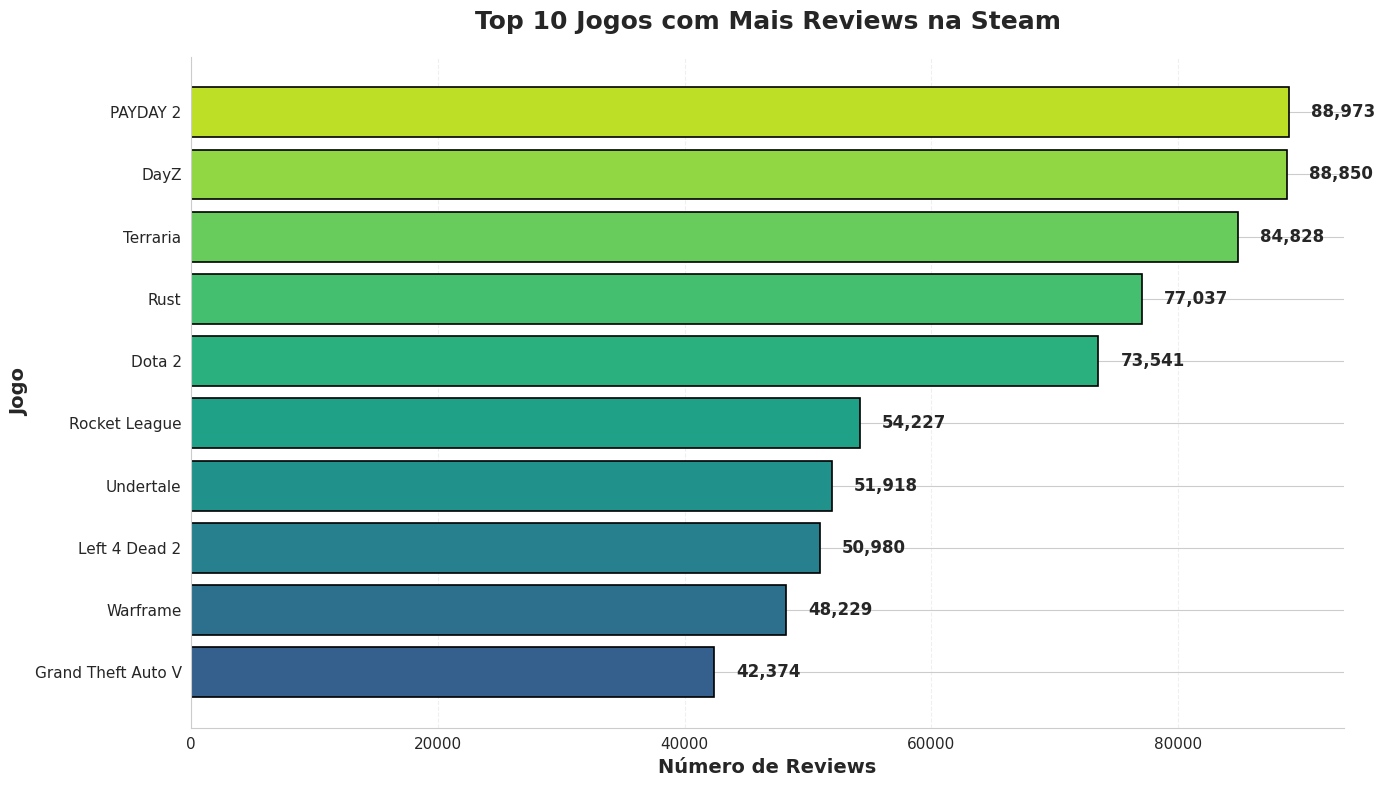

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))

top10_sorted = top10_pandas.sort_values('total_reviews', ascending=True)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top10_sorted)))

bars = ax.barh(top10_sorted['app_name'], top10_sorted['total_reviews'],
               color=colors, edgecolor='black', linewidth=1.2)

for i, (bar, value) in enumerate(zip(bars, top10_sorted['total_reviews'])):
    ax.text(value + max(top10_sorted['total_reviews']) * 0.02,
            bar.get_y() + bar.get_height()/2,
            f'{value:,.0f}',
            va='center', ha='left', fontsize=12, fontweight='bold')

ax.set_xlabel('Número de Reviews', fontsize=14, fontweight='bold')
ax.set_ylabel('Jogo', fontsize=14, fontweight='bold')
ax.set_title('Top 10 Jogos com Mais Reviews na Steam',
             fontsize=18, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

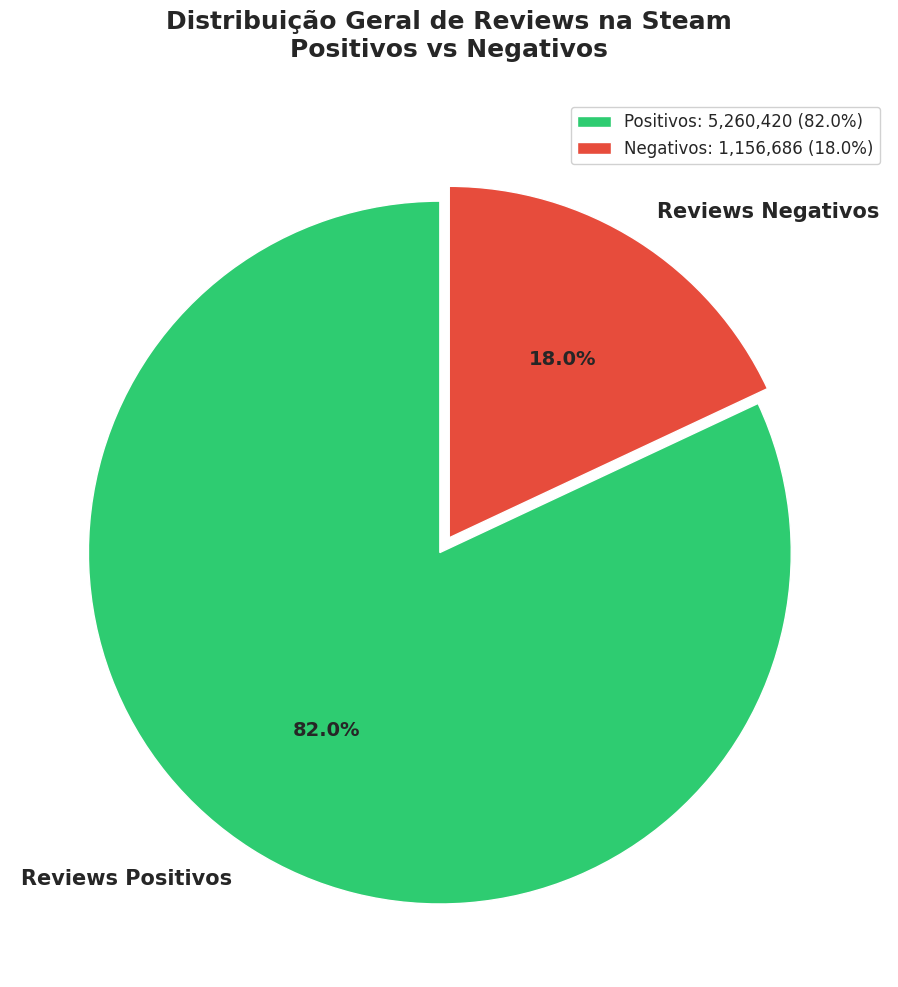

In [ ]:
positivos = sentiment_pandas[sentiment_pandas['sentimento'].str.contains('Positivo')]['count'].values[0]
negativos = sentiment_pandas[sentiment_pandas['sentimento'].str.contains('Negativo')]['count'].values[0]
total = positivos + negativos

# Calcular percentuais
pct_positivos = (positivos / total) * 100
pct_negativos = (negativos / total) * 100

# Criar figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dados para o gráfico
valores = [positivos, negativos]
labels = ['Reviews Positivos', 'Reviews Negativos']
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0)  # Destacar a fatia de positivos

# Criar gráfico de pizza
wedges, texts, autotexts = ax.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=90,
    textprops={'fontsize': 14, 'fontweight': 'bold'}
)

# Estilizar os labels
for text in texts:
    text.set_fontsize(15)
    text.set_fontweight('bold')

# Título
ax.set_title('Distribuição Geral de Reviews na Steam\nPositivos vs Negativos',
             fontsize=18, fontweight='bold', pad=30)

# Adicionar legenda com valores absolutos
legend_labels = [
    f'Positivos: {positivos:,} ({pct_positivos:.1f}%)',
    f'Negativos: {negativos:,} ({pct_negativos:.1f}%)'
]
ax.legend(legend_labels, loc='upper right', fontsize=12, framealpha=0.9)

plt.tight_layout()
plt.show()


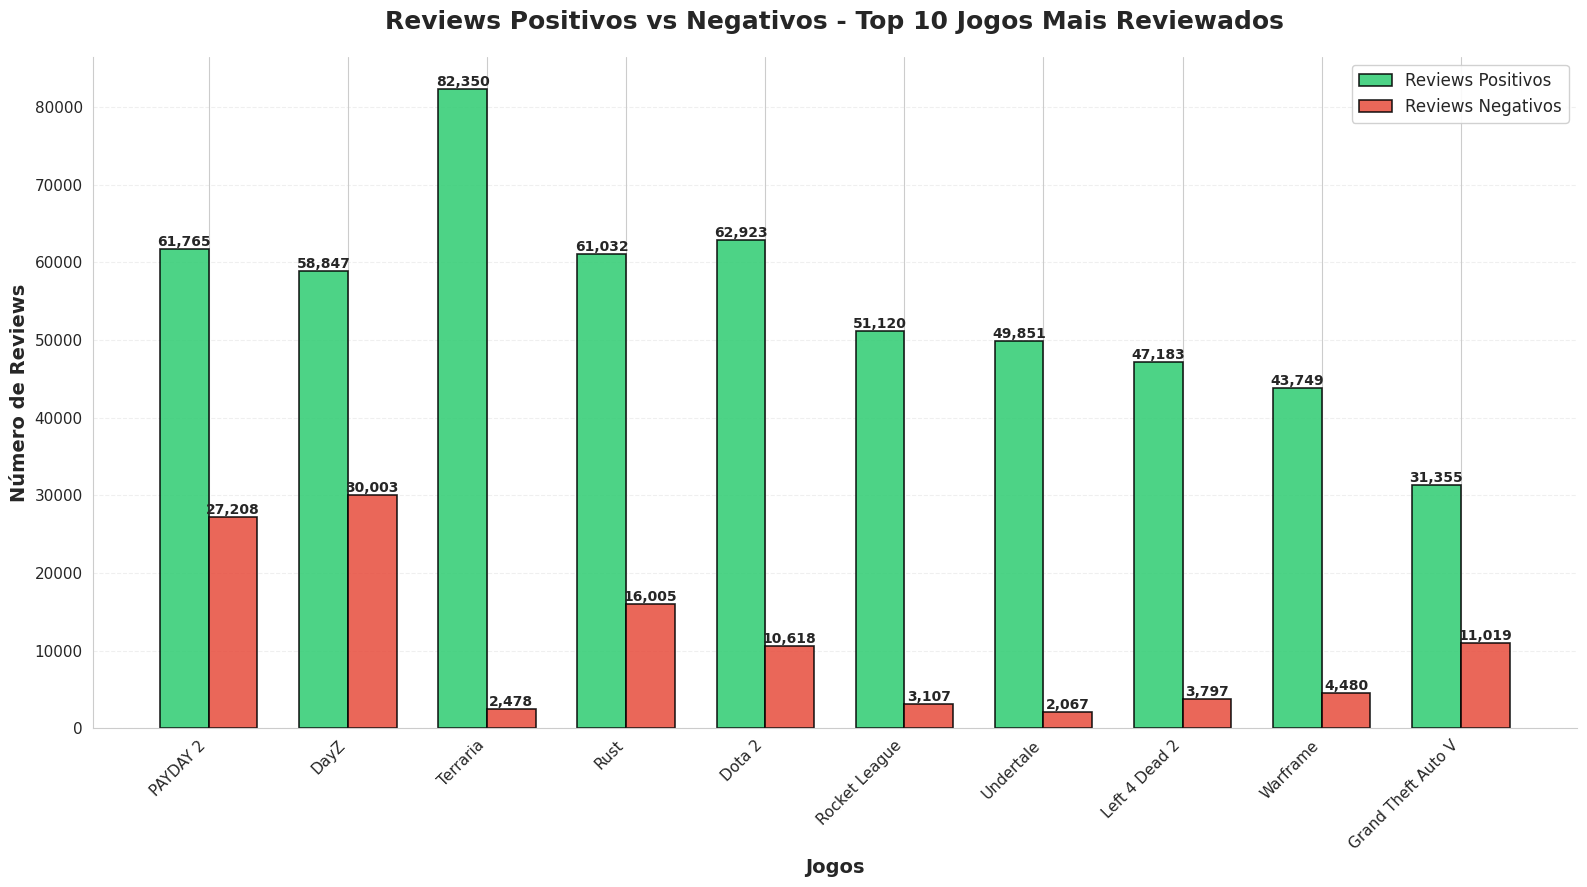

In [16]:
top10_sorted = top10_pandas.sort_values('total_reviews', ascending=False)

# Configuração
fig, ax = plt.subplots(figsize=(16, 9))

# Posições das barras
x = np.arange(len(top10_sorted))
width = 0.35  # Largura das barras

# Criar barras
bars1 = ax.bar(x - width/2, top10_sorted['positivos'], width,
               label='Reviews Positivos', color='#2ecc71',
               alpha=0.85, edgecolor='black', linewidth=1.2)

bars2 = ax.bar(x + width/2, top10_sorted['negativos'], width,
               label='Reviews Negativos', color='#e74c3c',
               alpha=0.85, edgecolor='black', linewidth=1.2)

# Adicionar valores em cima das barras
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Configurações do gráfico
ax.set_xlabel('Jogos', fontsize=14, fontweight='bold')
ax.set_ylabel('Número de Reviews', fontsize=14, fontweight='bold')
ax.set_title('Reviews Positivos vs Negativos - Top 10 Jogos Mais Reviewados',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(top10_sorted['app_name'], rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='upper right', framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()